In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"supratsaha","key":"938b3426ead55279e2d16f2ff8d2a57c"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:21<00:00, 205MB/s]
100% 2.29G/2.29G [00:21<00:00, 115MB/s]


In [4]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [31]:
import os, shutil
import numpy as np
import pandas as pd
import cv2
import skimage.segmentation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [32]:
"""
This function:
1. Reads X-ray images from folders
2. Converts them to grayscale
3. Resizes them to 128×128
4. Assigns numerical labels
5. Returns data ready for CNN training

"""
labels = ['PNEUMONIA','NORMAL']
img_size = 128
def get_data(data_dir):
    X = []  # images
    y = []  # labels

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_arr is None:
                    continue  # skip broken images

                resized_arr = cv2.resize(img_arr, (img_size, img_size))

                X.append(resized_arr)
                y.append(class_num)

            except Exception as e:
                print(e)

    return np.array(X), np.array(y)

In [33]:
X_train, y_train = get_data("chest_xray/chest_xray/train")
X_test, y_test = get_data("chest_xray/chest_xray/test")
X_val, y_val = get_data("chest_xray/chest_xray/val")

In [34]:
X_train.shape , y_train.shape

((5216, 128, 128), (5216,))

In [35]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

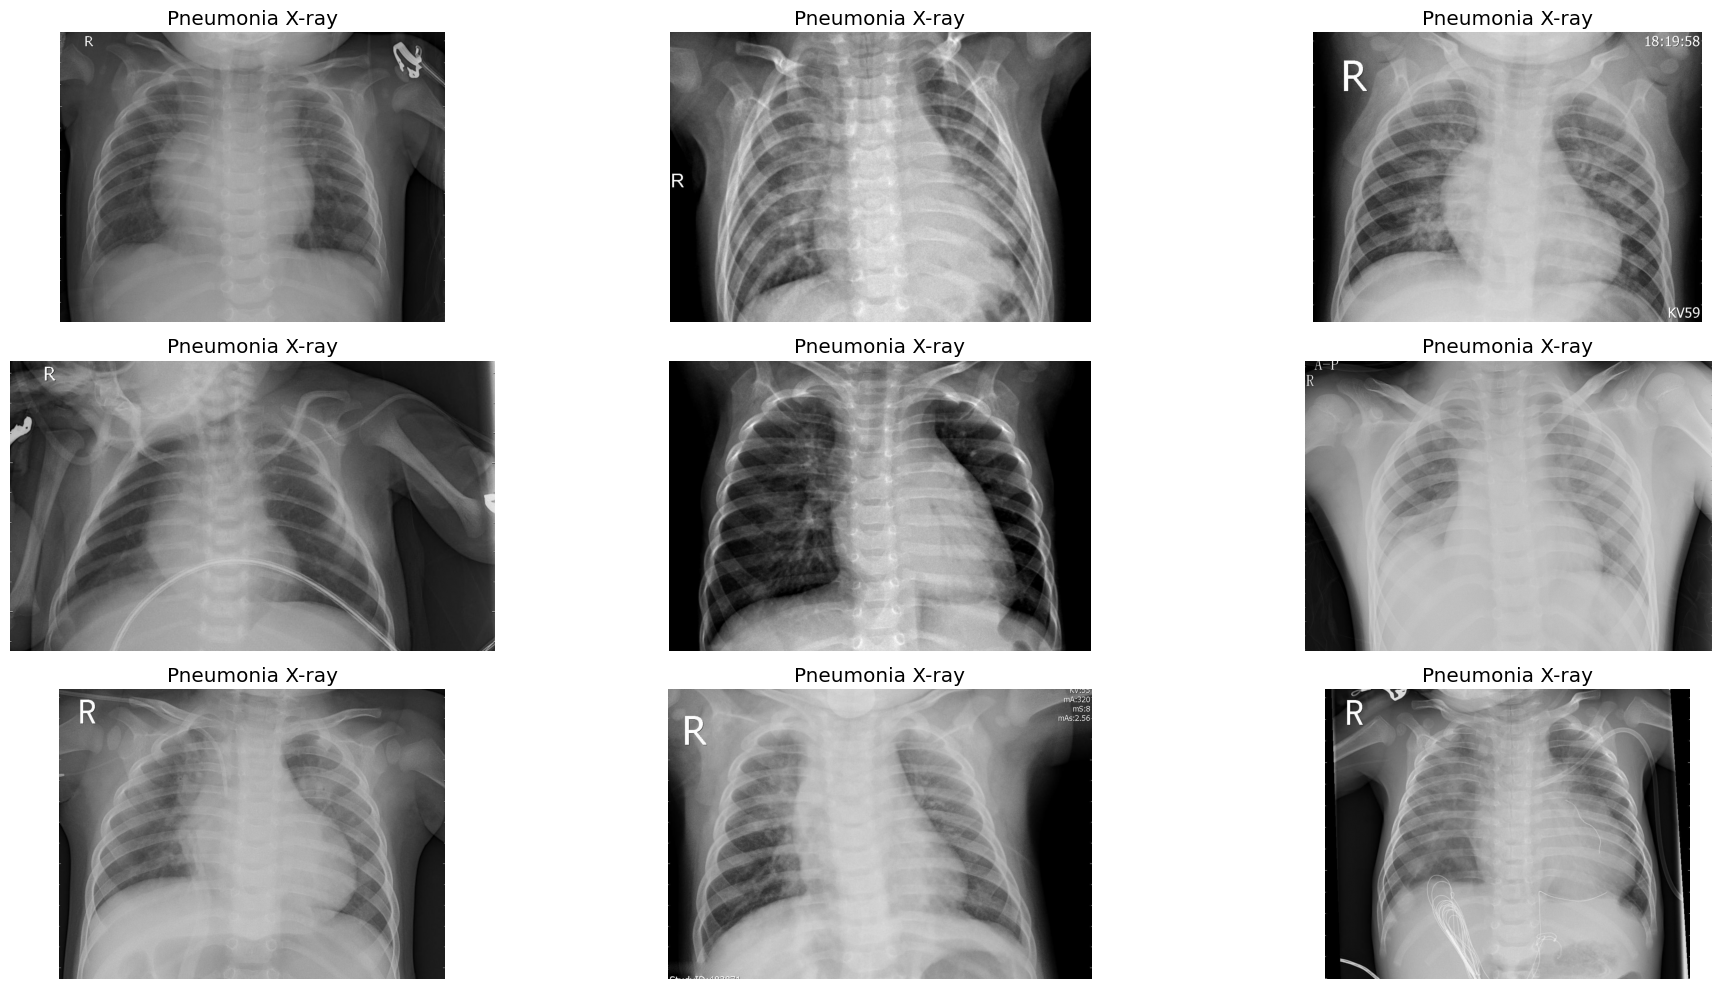

In [36]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir,pneumonia[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Pneumonia X-ray")
plt.tight_layout()

In [37]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

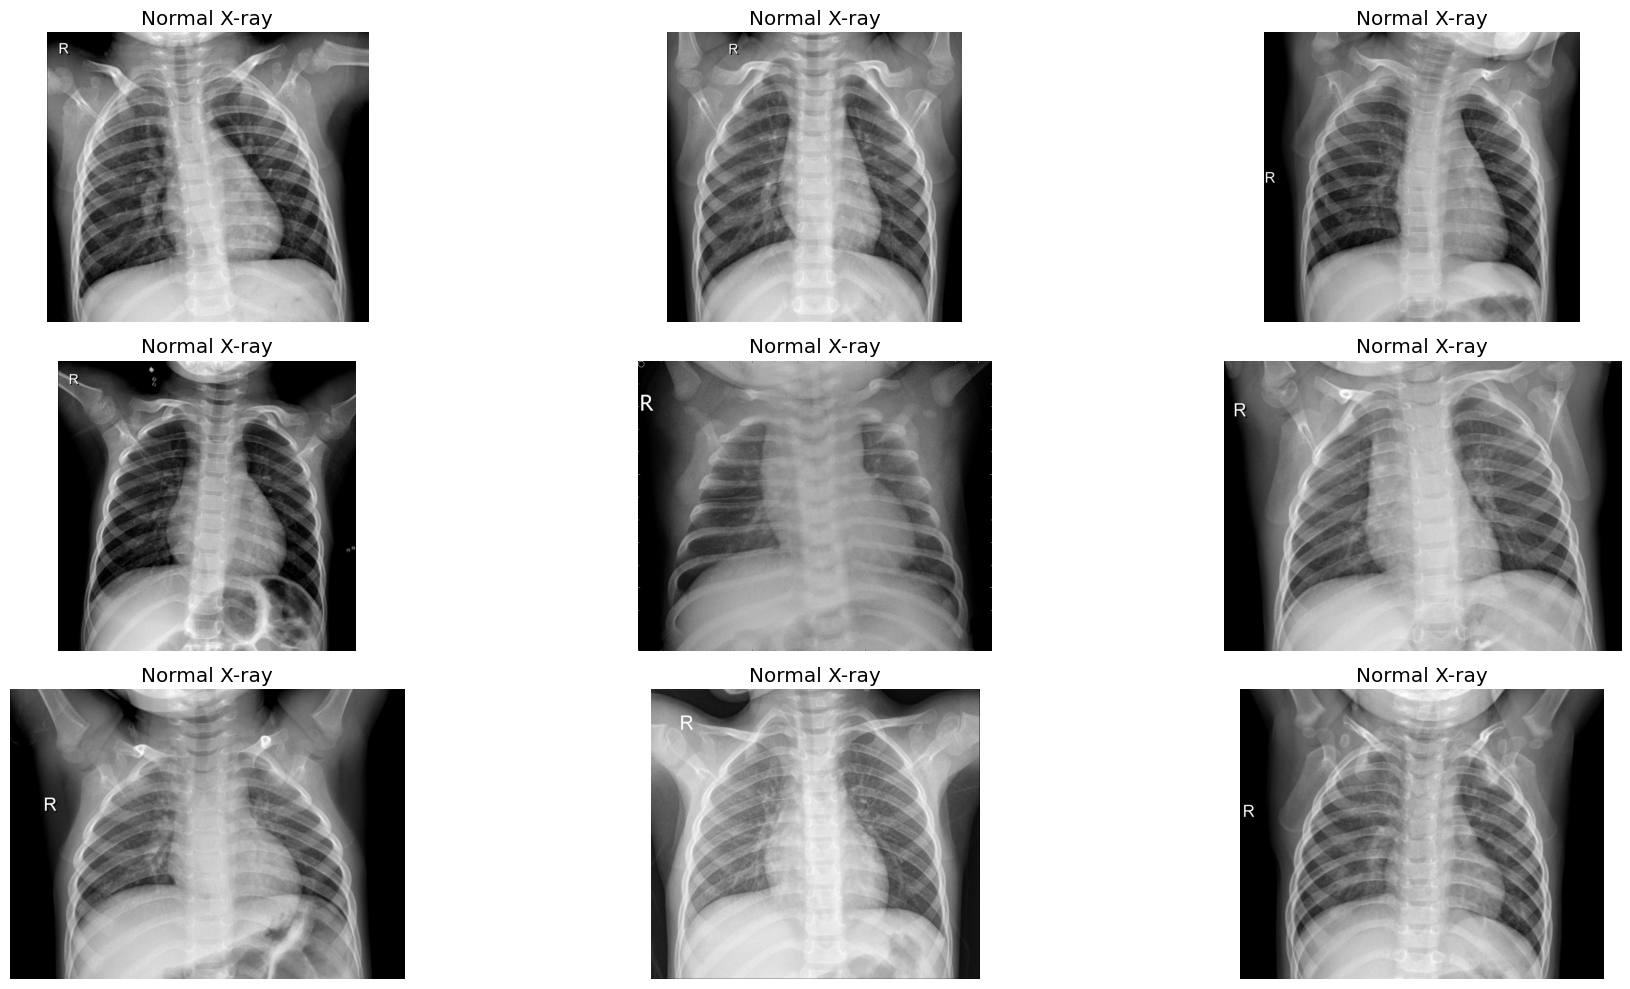

In [38]:
plt.figure(figsize=(20, 10))

for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(normal_dir,normal[i]))
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title("Normal X-ray")
plt.tight_layout()

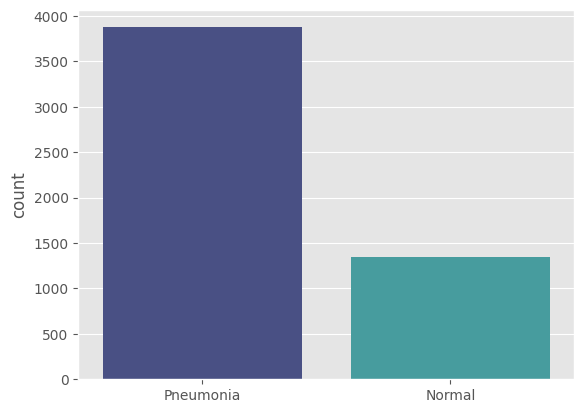

In [39]:
lst = []
for label in y_train:
    if label == 0:
        lst.append("Pneumonia")
    else:
        lst.append("Normal")

sns.countplot(x=lst, palette="mako")
plt.show()

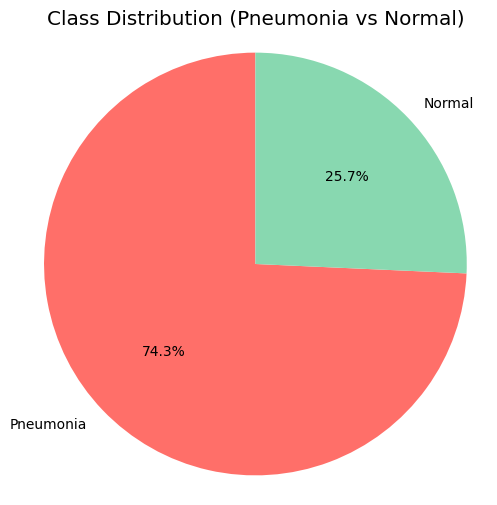

In [40]:
from collections import Counter

# Count classes
counts = Counter(lst)

labels = counts.keys()
sizes = counts.values()

plt.figure(figsize=(6, 6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff6f69', '#88d8b0']
)
plt.title("Class Distribution (Pneumonia vs Normal)")
plt.axis('equal')  # makes the pie chart circular
plt.show()

### Data Augmentation & Resizing

In [41]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten,Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [42]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode="nearest"
)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [43]:
train_generator = train_datagen.flow_from_directory("chest_xray/chest_xray/train",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
valid_generator = valid_datagen.flow_from_directory("chest_xray/chest_xray/val",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')
test_generator = test_datagen.flow_from_directory("chest_xray/chest_xray/test",
                                 batch_size = 32,
                                 target_size=(128,128),
                                 class_mode = 'categorical',
                                 shuffle=True,
                                 seed = 42,
                                 color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [44]:
class_labels = train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [45]:
class_name = {value: key for (key, value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

### VGG19 Architechture

In [46]:
# This model uses transfer learning with a pretrained VGG19 network as a frozen feature extractor and
# a custom dense classifier to perform binary pneumonia classification from chest X-rays.

vgg19_base_model = VGG19(input_shape = (128,128,3),
                     include_top = False,
                     weights = 'imagenet')
## Freeze all th layers of base model
for layer in vgg19_base_model.layers:
    layer.trainable = False

x = vgg19_base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(dropout)
output = Dense(2, activation = 'softmax')(class_2)

vgg19_model_01 = Model(vgg19_base_model.inputs, output)
vgg19_model_01.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [47]:
for layer in vgg19_model_01.layers:
    print(layer.name, layer.trainable)

input_layer_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_conv4 False
block5_pool False
flatten_2 True
dense_6 True
dropout_2 True
dense_7 True
dense_8 True


In [48]:
# Training configuration - How model learns, stops, adjust learning rate, and saves the best version
filepath = "vgg19_best.h5"

earlystopping = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
checkpoint=ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
sgd = SGD(learning_rate=1e-4, decay = 1e-6, momentum=0.9, nesterov = True)

vgg19_model_01.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [49]:
history_01 = vgg19_model_01.fit(train_generator,
            steps_per_epoch=50,
            epochs=30,
            callbacks=[earlystopping, checkpoint, lrr],
            validation_data=valid_generator)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6917 - loss: 0.6098

50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 490ms/step - accuracy: 0.6928 - loss: 0.6082 - val_accuracy: 0.5000 - val_loss: 0.6956 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8109 - loss: 0.3808

50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 490ms/step - accuracy: 0.8114 - loss: 0.3805 - val_accuracy: 0.7500 - val_loss: 0.4949 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8572 - loss: 0.3283

50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 464ms/step - accuracy: 0.8573 - loss: 0.3282 - val_accuracy: 0.8125 - val_loss: 0.4732 - learning_rate: 1.0000e-04
Epoch 4/30
13/50 ━━━━━━━━━━━━━━━━━━━━ 8s 226ms/step - accuracy: 0.9095 - loss: 0.2796

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 168ms/step - accuracy: 0.9000 - loss: 0.2877 - val_accuracy: 0.8750 - val_loss: 0.4606 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.8882 - loss: 0.2968

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 665ms/step - accuracy: 0.8880 - loss: 0.2968 - val_accuracy: 0.8125 - val_loss: 0.3914 - learning_rate: 1.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 378ms/step - accuracy: 0.8845 - loss: 0.2784 - val_accuracy: 0.6875 - val_loss: 0.5228 - learning_rate: 1.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 395ms/step - accuracy: 0.8988 - loss: 0.2629 - val_accuracy: 0.8750 - val_loss: 0.4255 - learning_rate: 1.0000e-04
Epoch 8/30
13/50 ━━━━━━━━━━━━━━━━━━━━ 13s 360ms/step - accuracy: 0.9061 - loss: 0.2532

50/50 ━━━━━━━━━━━━━━━━━━━━ 26s 529ms/step - accuracy: 0.8902 - loss: 0.2698 - val_accuracy: 0.8125 - val_loss: 0.3913 - learning_rate: 1.0000e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.9142 - loss: 0.2389 - val_accuracy: 0.8750 - val_loss: 0.4596 - learning_rate: 1.0000e-04
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 404ms/step - accuracy: 0.9064 - loss: 0.2339 - val_accuracy: 0.8125 - val_loss: 0.3937 - learning_rate: 1.0000e-04
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.9136 - loss: 0.2256 - val_accuracy: 0.8750 - val_loss: 0.4322 - learning_rate: 1.0000e-04
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.9535 - loss: 0.1882 - val_accuracy: 0.8750 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 12: early stopping


In [50]:
# Load the model weights
from tensorflow.keras.models import load_model

vgg19_model = load_model("vgg19_best.h5")

vgg19_val_eval_01 = vgg19_model.evaluate(valid_generator)
vgg19_test_eval_01 = vgg19_model.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8125 - loss: 0.3913
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8029 - loss: 0.4122


In [51]:
print(f"Validation Loss: {vgg19_val_eval_01[0]}")
print(f"Validation Accuarcy: {vgg19_val_eval_01[1]}")
print(f"Test Loss: {vgg19_test_eval_01[0]}")
print(f"Test Accuarcy: {vgg19_test_eval_01[1]}")

Validation Loss: 0.391332745552063
Validation Accuarcy: 0.8125
Test Loss: 0.3893958032131195
Test Accuarcy: 0.8285256624221802


## Increamental unfreezing & fine tuning

In [52]:
vgg19_base_model_layer_names = [layer.name for layer in vgg19_base_model.layers]
print("Number of layers in the Vgg19 base model: ", len(vgg19_base_model.layers))
print("Last 5 layers: ", vgg19_base_model_layer_names[-5:])
vgg19_base_model_layer_names

Number of layers in the Vgg19 base model:  22
Last 5 layers:  ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4', 'block5_pool']


['input_layer_2',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [53]:
vgg19_base_model = VGG19(
    include_top=False,
    input_shape=(128,128,3),
    weights="imagenet"
)

# Freeze everything
for layer in vgg19_base_model.layers:
    layer.trainable = False

# Unfreeze last 2 conv layers
for layer in vgg19_base_model.layers:
    if layer.name in ['block5_conv3', 'block5_conv4']:
        layer.trainable = True


x = vgg19_base_model.output
flat = Flatten()(x)
class_1 = Dense(4608, activation='relu')(flat)
dropout = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation='relu')(dropout)
output = Dense(2, activation='softmax')(class_2)

Vgg19_model_tuned = Model(vgg19_base_model.input, output)

Vgg19_model_tuned.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4608)           │             

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 47,784,834 (182.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

In [54]:
for layer in Vgg19_model_tuned.layers:
    print(layer.name, layer.trainable)

input_layer_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_conv4 True
block5_pool False
flatten_3 True
dense_9 True
dropout_3 True
dense_10 True
dense_11 True


In [55]:
earlystopping = EarlyStopping(monitor="val_loss", verbose=1, mode="min", patience=4)
checkpoint=ModelCheckpoint("vgg19_tuned_best.h5", monitor="val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=0.0001)
sgd = SGD(learning_rate=1e-4, decay = 1e-6, momentum=0.9, nesterov = True)

Vgg19_model_tuned.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])

In [56]:
history_02 = Vgg19_model_tuned.fit(train_generator,
            steps_per_epoch=50,
            epochs=30,
            callbacks=[earlystopping, checkpoint, lrr],
            validation_data=valid_generator)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.7170 - loss: 0.5776

50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 538ms/step - accuracy: 0.7181 - loss: 0.5759 - val_accuracy: 0.6875 - val_loss: 0.5223 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8423 - loss: 0.3538

50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 562ms/step - accuracy: 0.8427 - loss: 0.3534 - val_accuracy: 0.8750 - val_loss: 0.4069 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8776 - loss: 0.2910

50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 443ms/step - accuracy: 0.8777 - loss: 0.2908 - val_accuracy: 0.8750 - val_loss: 0.3881 - learning_rate: 1.0000e-04
Epoch 4/30
13/50 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - accuracy: 0.9088 - loss: 0.2596

50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 0.9105 - loss: 0.2623 - val_accuracy: 0.8750 - val_loss: 0.3667 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9045 - loss: 0.2326

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 533ms/step - accuracy: 0.9045 - loss: 0.2327 - val_accuracy: 0.8750 - val_loss: 0.3429 - learning_rate: 1.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.9035 - loss: 0.2314 - val_accuracy: 0.8750 - val_loss: 0.3560 - learning_rate: 1.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 393ms/step - accuracy: 0.9340 - loss: 0.1903 - val_accuracy: 0.8750 - val_loss: 0.4264 - learning_rate: 1.0000e-04
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9068 - loss: 0.2228 - val_accuracy: 0.8750 - val_loss: 0.3505 - learning_rate: 1.0000e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 387ms/step - accuracy: 0.9085 - loss: 0.2270 - val_accuracy: 0.8750 - val_loss: 0.3952 - learning_rate: 1.0000e-04
Epoch 9: early stopping


In [57]:
vgg19_tuned_best_model =load_model("vgg19_tuned_best.h5")

vgg19_val_eval_02 = vgg19_tuned_best_model.evaluate(valid_generator)
vgg19_test_eval_02 = vgg19_tuned_best_model.evaluate(test_generator)

print(f"Validation Loss: {vgg19_val_eval_02[0]}")
print(f"Validation Accuarcy: {vgg19_val_eval_02[1]}")
print(f"Test Loss: {vgg19_test_eval_02[0]}")
print(f"Test Accuarcy: {vgg19_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8750 - loss: 0.3429
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.8306 - loss: 0.3572
Validation Loss: 0.34292587637901306
Validation Accuarcy: 0.875
Test Loss: 0.348740816116333
Test Accuarcy: 0.8317307829856873


## EfficientNetB3 Model
EfficientNet-B3 applies compound scaling to achieve higher accuracy with fewer parameters, making it more efficient and better suited for medical imaging tasks

In [58]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

In [59]:
# Training generator with augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # REQUIRED
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation & Test Generators (NO augmentation)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [60]:
train_generator = train_datagen.flow_from_directory(
    "chest_xray/train",
    target_size=(300, 300),   # REQUIRED for EfficientNet-B3
    batch_size=16,
    class_mode="binary",
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    "chest_xray/val",
    target_size=(300, 300),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    "chest_xray/test",
    target_size=(300, 300),
    batch_size=16,
    class_mode="binary",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [61]:
print(train_generator.class_indices)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [62]:
x_batch, y_batch = next(train_generator)
print(x_batch.shape, y_batch.shape)

(16, 300, 300, 3) (16,)


In [63]:
EfficientNetB3_base_model = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze the Base model
for layer in EfficientNetB3_base_model.layers:
    layer.trainable = False

x = EfficientNetB3_base_model.output
x = GlobalAveragePooling2D()(x)   # BETTER than Flatten
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

efficientNetB3_model = Model(inputs=EfficientNetB3_base_model.input, outputs=output)
efficientNetB3_model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer_4[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 787,457 (3.00 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [64]:
print("Number of layers in the Vgg19 base model: ", len(EfficientNetB3_base_model.layers))

Number of layers in the Vgg19 base model:  385


In [65]:
for layer in efficientNetB3_model.layers:
    print(layer.name, layer.trainable)

input_layer_4 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False

In [66]:
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau
)

# Stop when validation loss stops improving
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Save the best model
checkpoint = ModelCheckpoint(
    "efficientnet_b3_best.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Reduce LR when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [67]:
efficientNetB3_model.compile( optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [68]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

In [69]:
history = efficientNetB3_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8729 - loss: 0.2775
Epoch 1: val_loss improved from inf to 0.17302, saving model to efficientnet_b3_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 208s 501ms/step - accuracy: 0.8731 - loss: 0.2773 - val_accuracy: 0.9375 - val_loss: 0.1730 - learning_rate: 1.0000e-04
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.9404 - loss: 0.1490
Epoch 2: val_loss improved from 0.17302 to 0.09782, saving model to efficientnet_b3_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 437ms/step - accuracy: 0.9404 - loss: 0.1490 - val_accuracy: 1.0000 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9521 - loss: 0.1239
Epoch 3: val_loss improved from 0.09782 to 0.08935, saving model to efficientnet_b3_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 142s 436ms/step - accuracy: 0.9521 - loss: 0.1239 - val_accuracy: 1.0000 - val_loss: 0.0894 - learning_rate: 1.0000e-04
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9567 - loss: 0.1187
Epoch 4: val_loss improved from 0.08935 to 0.06594, saving model to efficientnet_b3_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 438ms/step - accuracy: 0.9567 - loss: 0.1187 - val_accuracy: 1.0000 - val_loss: 0.0659 - learning_rate: 1.0000e-04
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.9608 - loss: 0.1021
Epoch 5: val_loss did not improve from 0.06594
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 433ms/step - accuracy: 0.9608 - loss: 0.1021 - val_accuracy: 1.0000 - val_loss: 0.0785 - learning_rate: 1.0000e-04
Epoch 6/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9609 - loss: 0.0997
Epoch 6: val_loss did not improve from 0.06594
326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 437ms/step - accuracy: 0.9609 - loss: 0.0997 - val_accuracy: 0.9375 - val_loss: 0.0959 - learning_rate: 1.0000e-04
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9646 - loss: 0.0860
Epoch 7: val_loss did not improve from 0.06594

Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.9646 - loss:

326/326 ━━━━━━━━━━━━━━━━━━━━ 144s 443ms/step - accuracy: 0.9661 - loss: 0.0892 - val_accuracy: 1.0000 - val_loss: 0.0530 - learning_rate: 5.0000e-05
Epoch 9/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9715 - loss: 0.0764
Epoch 9: val_loss did not improve from 0.05304
326/326 ━━━━━━━━━━━━━━━━━━━━ 143s 437ms/step - accuracy: 0.9715 - loss: 0.0764 - val_accuracy: 1.0000 - val_loss: 0.0537 - learning_rate: 5.0000e-05
Epoch 10/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.9707 - loss: 0.0746
Epoch 10: val_loss did not improve from 0.05304
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 432ms/step - accuracy: 0.9707 - loss: 0.0747 - val_accuracy: 1.0000 - val_loss: 0.0606 - learning_rate: 5.0000e-05
Epoch 11/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9718 - loss: 0.0800
Epoch 11: val_loss did not improve from 0.05304

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 141s 431ms/step - accuracy: 0.9718 - 

In [70]:
efficientB3 = load_model("efficientnet_b3_best.h5")

eff_val_eval_01 = efficientB3.evaluate(valid_generator)
eff_test_eval_01 = efficientB3.evaluate(test_generator)

print(f"Validation Loss: {eff_val_eval_01[0]}")
print(f"Validation Accuarcy: {eff_val_eval_01[1]}")
print(f"Test Loss: {eff_test_eval_01[0]}")
print(f"Test Accuarcy: {eff_test_eval_01[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 1.0000 - loss: 0.0530
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 0.7624 - loss: 0.6159
Validation Loss: 0.05304186791181564
Validation Accuarcy: 1.0
Test Loss: 0.36822575330734253
Test Accuarcy: 0.8541666865348816


## Incremental unfreezing and Fine tunning

In [71]:
EfficientNetB3_base_model = EfficientNetB3(
    input_shape=(300, 300, 3),
    include_top=False,
    weights="imagenet"
)

# Unfreeze top layers of EfficientNet
for layer in EfficientNetB3_base_model.layers[-40:]:
    layer.trainable = True

x = EfficientNetB3_base_model.output
x = GlobalAveragePooling2D()(x)   # BETTER than Flatten
x = Dense(512, activation="relu")(x)
x = Dropout(0.3)(x)

output = Dense(1, activation="sigmoid")(x)

model_efficientNet_tuned = Model(inputs=EfficientNetB3_base_model.input, outputs=output)
model_efficientNet_tuned.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 300, 300,  │          0 │ input_layer_5[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 300, 300,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 300, 300,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,570,992 (44.14 MB)

 Trainable params: 11,483,689 (43.81 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [72]:
model_efficientNet_tuned.compile( optimizer=Adam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [73]:
history_tuned = model_efficientNet_tuned.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

Epoch 1/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9184 - loss: 0.2092
Epoch 1: val_loss did not improve from 0.05304
326/326 ━━━━━━━━━━━━━━━━━━━━ 296s 532ms/step - accuracy: 0.9185 - loss: 0.2090 - val_accuracy: 1.0000 - val_loss: 0.0604 - learning_rate: 1.0000e-04
Epoch 2/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9782 - loss: 0.0572
Epoch 2: val_loss improved from 0.05304 to 0.03182, saving model to efficientnet_b3_best.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 163s 499ms/step - accuracy: 0.9782 - loss: 0.0572 - val_accuracy: 1.0000 - val_loss: 0.0318 - learning_rate: 1.0000e-04
Epoch 3/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.9831 - loss: 0.0511
Epoch 3: val_loss did not improve from 0.03182
326/326 ━━━━━━━━━━━━━━━━━━━━ 160s 491ms/step - accuracy: 0.9831 - loss: 0.0511 - val_accuracy: 1.0000 - val_loss: 0.0467 - learning_rate: 1.0000e-04
Epoch 4/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9872 - loss: 0.0379
Epoch 4: val_loss did not improve from 0.03182
326/326 ━━━━━━━━━━━━━━━━━━━━ 162s 495ms/step - accuracy: 0.9872 - loss: 0.0379 - val_accuracy: 1.0000 - val_loss: 0.0341 - learning_rate: 1.0000e-04
Epoch 5/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9838 - loss: 0.0411
Epoch 5: val_loss did not improve from 0.03182

Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 161s 495ms/step - accuracy: 0.9839 - loss:

326/326 ━━━━━━━━━━━━━━━━━━━━ 162s 496ms/step - accuracy: 0.9913 - loss: 0.0262 - val_accuracy: 1.0000 - val_loss: 0.0235 - learning_rate: 5.0000e-05
Epoch 7/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9978 - loss: 0.0068
Epoch 7: val_loss did not improve from 0.02345
326/326 ━━━━━━━━━━━━━━━━━━━━ 161s 494ms/step - accuracy: 0.9978 - loss: 0.0068 - val_accuracy: 0.9375 - val_loss: 0.0616 - learning_rate: 5.0000e-05
Epoch 8/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.9954 - loss: 0.0140
Epoch 8: val_loss did not improve from 0.02345
326/326 ━━━━━━━━━━━━━━━━━━━━ 161s 493ms/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.9375 - val_loss: 0.1244 - learning_rate: 5.0000e-05
Epoch 9/30
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.9960 - loss: 0.0109
Epoch 9: val_loss did not improve from 0.02345

Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 163s 498ms/step - accuracy: 0.9960 - loss:

### Model Evaluation

In [74]:
eff_tuned_val_score = model_efficientNet_tuned.evaluate(valid_generator)
eff_tuned_test_score = model_efficientNet_tuned.evaluate(test_generator)

print(f"Validation Loss: {eff_tuned_val_score[0]}")
print(f"Validation Accuracy: {eff_tuned_val_score[1]}")
print(f"Test Loss: {eff_tuned_test_score[0]}")
print(f"Test Accuracy: {eff_tuned_test_score[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 1.0000 - loss: 0.0235
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9043 - loss: 0.3541
Validation Loss: 0.0234526339918375
Validation Accuracy: 1.0
Test Loss: 0.2750357985496521
Test Accuracy: 0.9294871687889099


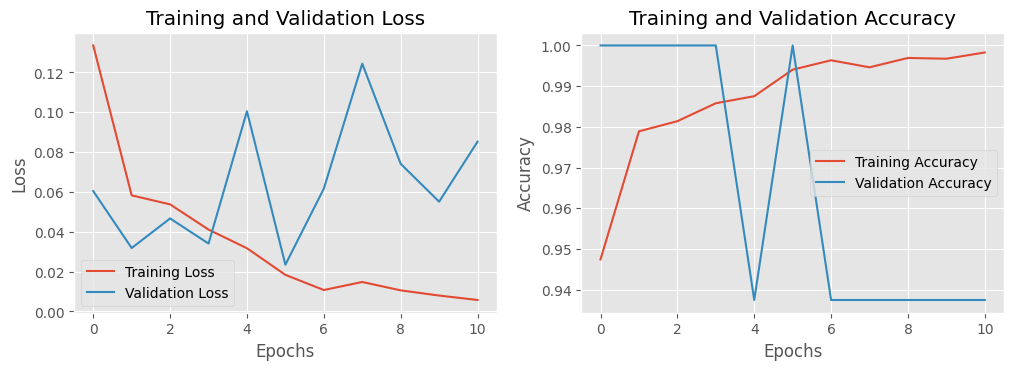

In [75]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(history_tuned.history['loss'], label='Training Loss')
plt.plot(history_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

In [76]:
if not os.path.isdir('model_weights/'):
    os.mkdir("model_weights/")
model_efficientNet_tuned.save(filepath = "model_weights/efficientNet_model_tuned.h5", overwrite=True)

### After tunning on EfficientNetB3 model, we got accuracy on test data ~92%. So we've selected EfficientNetB3 model (Tuned version). Let's see few performance metrics of this model

In [77]:
final_model = tf.keras.models.load_model("model_weights/efficientNet_model_tuned.h5")


In [78]:
# Get true labels from generator
y_true = test_generator.classes

In [79]:
# Get model prediction

# Predict probabilities
y_pred_prob = final_model.predict(test_generator)

# Convert probabilities → class labels (0 / 1)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)


39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step


In [80]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_true, y_pred)

# Plotting Confusion Matrix

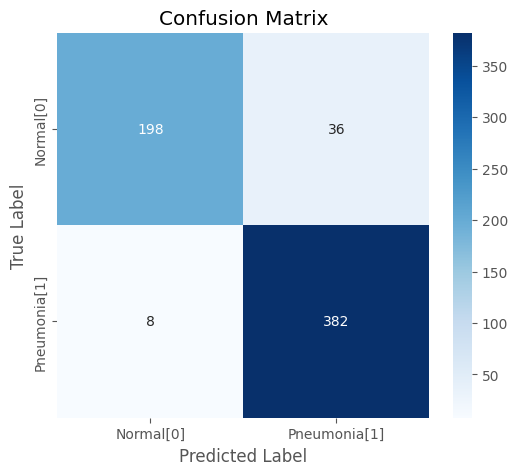

In [81]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Normal[0]", "Pneumonia[1]"],
    yticklabels=["Normal[0]", "Pneumonia[1]"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### Classification Report

In [82]:
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Normal", "Pneumonia"]
    )
)

              precision    recall  f1-score   support

      Normal       0.96      0.85      0.90       234
   Pneumonia       0.91      0.98      0.95       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [85]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, roc_curve
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_prob)
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("ROC-AUC:", auc)

F1-Score: 0.9455445544554455
Precision: 0.9138755980861244
Recall: 0.9794871794871794
ROC-AUC: 0.9727920227920227


In [87]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

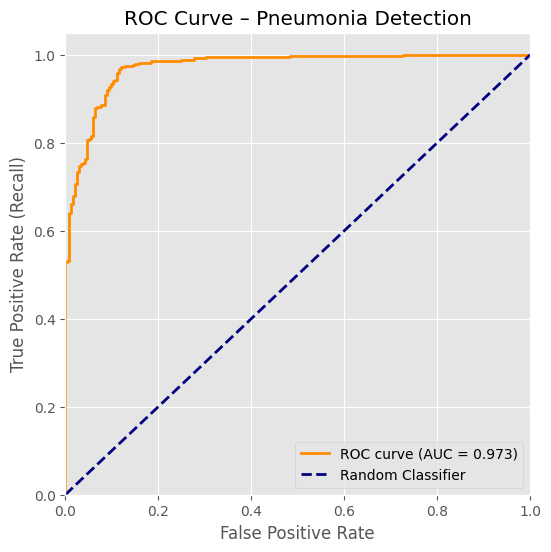

In [88]:
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2,
         label=f"ROC curve (AUC = {roc_auc_value:.3f})")

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--",
         label="Random Classifier")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Pneumonia Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

After fine-tuning the model, I evaluated performance using a confusion matrix and classification report to analyze false negatives, recall, and F1-score, which are critical metrics for medical diagnosis tasks